In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.keras import TqdmCallback
import torch
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Activation, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

In [ ]:
import os
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"melikaabadi","key":"87afcde48a1f15d849ec1cb8a49c936d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented

Dataset URL: https://www.kaggle.com/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented
License(s): MIT


In [ ]:
!unzip iq-othnccd-lung-cancer-dataset-augmented.zip -d lung-cancer-dataset-augmented

Archive:  iq-othnccd-lung-cancer-dataset-augmented.zip
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Augmentation Details.txt  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (1).jpg  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (10).jpg  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (100).jpg  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (101).jpg  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (102).jpg  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (103).jpg  
  inflating: lung-cancer-dataset-augmented/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases/Bengin case (1

**GPU**

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

!nvidia-smi

Thu Mar 20 20:02:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print("Is CUDA available?", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.get_device_name(0))

Is CUDA available? True
GPU count: 1
Current GPU: Tesla T4


In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow is using GPU?" , tf.test.is_gpu_available())
print("Current Device:", tf.config.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available: 1
TensorFlow is using GPU? True
Current Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**CNN with pytorch**

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau , CyclicLR
from PIL import Image
import random
import cv2
import torchvision.transforms as transforms
from torchvision.models import resnet50
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.optim as optim
import torchvision.models as models


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.RandomAffine(degrees=10, shear=0.15),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
train_dataset = ImageFolder(root='/content/lung-cancer-dataset-augmented/Augmented_IQ-OTHNCCD_lung_cancer_dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

val_dataset = ImageFolder(root='/content/lung-cancer-dataset-augmented/Augmented_IQ-OTHNCCD_lung_cancer_dataset', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
print(f"Classes: {train_dataset.classes}")

Classes: ['Benign cases', 'Malignant cases', 'Normal cases']


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)
print(model)

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
class_weights = torch.tensor([1.0, 1.5 , 1.2])
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30] → Loss: 0.9794, Accuracy: 50.79%


Validation Loss: 1.2180, Validation Accuracy: 33.33%


Epoch [2/30] → Loss: 0.8579, Accuracy: 62.15%


Validation Loss: 1.0710, Validation Accuracy: 45.00%


Epoch [3/30] → Loss: 0.8010, Accuracy: 66.36%


Validation Loss: 0.9796, Validation Accuracy: 49.65%


Epoch [4/30] → Loss: 0.7484, Accuracy: 68.97%


Validation Loss: 0.7807, Validation Accuracy: 68.00%


Epoch [5/30] → Loss: 0.7338, Accuracy: 70.91%


Validation Loss: 0.8014, Validation Accuracy: 67.05%


Epoch [6/30] → Loss: 0.7145, Accuracy: 69.02%


Validation Loss: 0.7367, Validation Accuracy: 72.96%


Epoch [7/30] → Loss: 0.6895, Accuracy: 72.85%


Validation Loss: 0.9067, Validation Accuracy: 55.92%


Epoch [8/30] → Loss: 0.6698, Accuracy: 73.29%


Validation Loss: 0.8506, Validation Accuracy: 65.48%


Epoch [9/30] → Loss: 0.6817, Accuracy: 73.18%


Validation Loss: 1.1787, Validation Accuracy: 49.79%


Epoch [10/30] → Loss: 0.6777, Accuracy: 74.01%


Validation Loss: 0.8455, Validation Accuracy: 63.73%


Epoch [11/30] → Loss: 0.6221, Accuracy: 77.67%


Validation Loss: 0.6529, Validation Accuracy: 78.58%


Epoch [12/30] → Loss: 0.6055, Accuracy: 78.91%


Validation Loss: 0.7488, Validation Accuracy: 66.78%


Epoch [13/30] → Loss: 0.6029, Accuracy: 78.86%


Validation Loss: 0.6707, Validation Accuracy: 76.59%


Epoch [14/30] → Loss: 0.5979, Accuracy: 79.38%


Validation Loss: 0.6252, Validation Accuracy: 78.14%


Epoch [15/30] → Loss: 0.5961, Accuracy: 79.30%


Validation Loss: 0.6052, Validation Accuracy: 83.07%


Epoch [16/30] → Loss: 0.5909, Accuracy: 79.33%


Validation Loss: 0.6254, Validation Accuracy: 80.69%


Epoch [17/30] → Loss: 0.5819, Accuracy: 80.99%


Validation Loss: 0.6100, Validation Accuracy: 82.57%


Epoch [18/30] → Loss: 0.5871, Accuracy: 81.55%


Validation Loss: 0.6930, Validation Accuracy: 77.09%


Epoch [19/30] → Loss: 0.5829, Accuracy: 80.91%


Validation Loss: 0.6275, Validation Accuracy: 78.42%


Epoch [20/30] → Loss: 0.5655, Accuracy: 82.63%


Validation Loss: 0.5916, Validation Accuracy: 82.65%


Epoch [21/30] → Loss: 0.5707, Accuracy: 81.63%


Validation Loss: 0.5934, Validation Accuracy: 82.74%


Epoch [22/30] → Loss: 0.5708, Accuracy: 82.18%


Validation Loss: 0.5878, Validation Accuracy: 84.10%


Epoch [23/30] → Loss: 0.5711, Accuracy: 82.02%


Validation Loss: 0.5866, Validation Accuracy: 83.35%


Epoch [24/30] → Loss: 0.5700, Accuracy: 81.80%


Validation Loss: 0.6128, Validation Accuracy: 81.71%


Epoch [25/30] → Loss: 0.5700, Accuracy: 82.68%


Validation Loss: 0.5880, Validation Accuracy: 82.96%


Epoch [26/30] → Loss: 0.5701, Accuracy: 82.21%


Validation Loss: 0.5865, Validation Accuracy: 84.01%


Epoch [27/30] → Loss: 0.5712, Accuracy: 82.27%


Validation Loss: 0.5850, Validation Accuracy: 84.10%


Epoch [28/30] → Loss: 0.5650, Accuracy: 83.04%


Validation Loss: 0.5902, Validation Accuracy: 83.32%


Epoch [29/30] → Loss: 0.5644, Accuracy: 82.90%


Validation Loss: 0.5898, Validation Accuracy: 83.29%


Epoch [30/30] → Loss: 0.5679, Accuracy: 82.60%


Validation Loss: 0.5832, Validation Accuracy: 84.76%


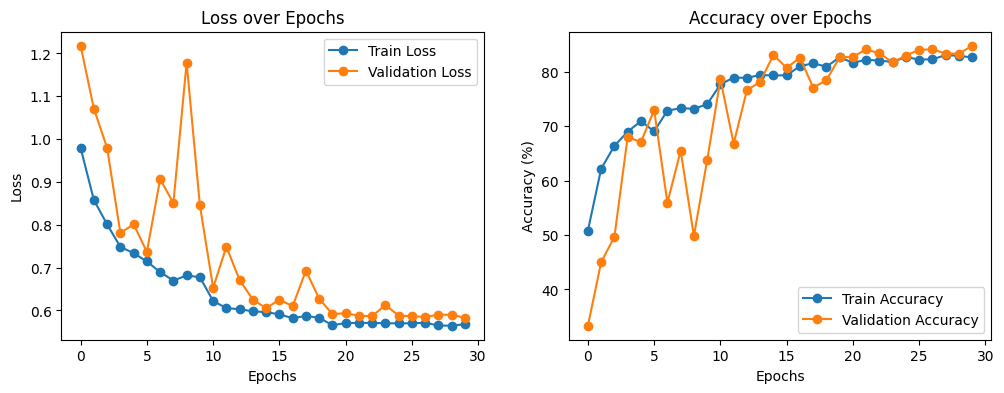

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 30
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix(loss=loss.item(), acc=100*correct/total)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] → Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * correct / total)

    print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.2f}%")
    scheduler.step(val_losses[-1])

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')

plt.show()

In [ ]:
torch.save(model.state_dict(), 'lung_cancer_cnn_model.pth')

In [ ]:
model.load_state_dict(torch.load('lung_cancer_cnn_model.pth'))
model.to(device)
model.eval()

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
def predict_image(image_path, model, transform, device):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).unsqueeze(0).to(device)
  model.eval()
  with torch.no_grad():
    output = model(image)
    _, predicted = output.max(1)
  return predicted.item()

In [ ]:
sample_indices = random.sample(range(len(val_dataset)), 10)

for idx in sample_indices:
  image, label = val_dataset[idx]
  image_path = val_dataset.samples[idx][0]

  predicted_class = predict_image(image_path, model, transform, device)
  print(f"Actual class:{train_dataset.classes[label]} --> predicted class: {train_dataset.classes[predicted_class]}")

Actual class:Benign cases --> predicted class: Normal cases
Actual class:Benign cases --> predicted class: Benign cases
Actual class:Benign cases --> predicted class: Benign cases
Actual class:Normal cases --> predicted class: Benign cases
Actual class:Normal cases --> predicted class: Normal cases
Actual class:Benign cases --> predicted class: Benign cases
Actual class:Malignant cases --> predicted class: Malignant cases
Actual class:Benign cases --> predicted class: Benign cases
Actual class:Benign cases --> predicted class: Benign cases
Actual class:Benign cases --> predicted class: Normal cases


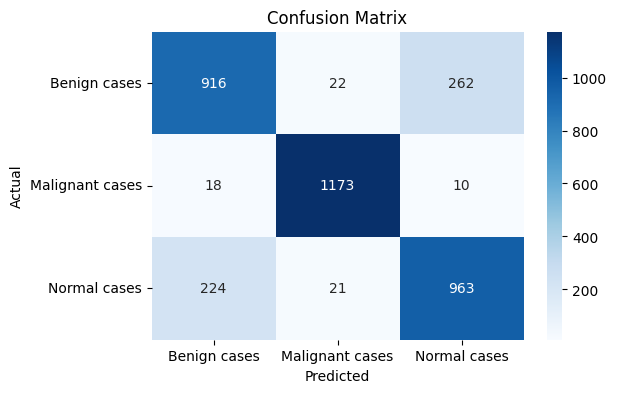

In [ ]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
classes = train_dataset.classes

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

                 precision    recall  f1-score   support

   Benign cases       0.79      0.76      0.78      1200
Malignant cases       0.96      0.98      0.97      1201
   Normal cases       0.78      0.80      0.79      1208

       accuracy                           0.85      3609
      macro avg       0.85      0.85      0.85      3609
   weighted avg       0.85      0.85      0.85      3609



**Resnet50**

In [ ]:
transform_resnet = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
train_dataset_resnet = ImageFolder(root='/content/lung-cancer-dataset-augmented/Augmented_IQ-OTHNCCD_lung_cancer_dataset', transform=transform_resnet)
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=128, shuffle=True, num_workers=2)

val_dataset_resnet = ImageFolder(root='/content/lung-cancer-dataset-augmented/Augmented_IQ-OTHNCCD_lung_cancer_dataset', transform=transform_resnet)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
model_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3)

model_resnet = model_resnet.to(device)
print(model_resnet)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model_resnet.parameters():
    param.requires_grad = False

#model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 3)

for param in model_resnet.layer4.parameters():
    param.requires_grad = True

In [ ]:
class_weights = torch.tensor([1.0, 1.5, 1.2]).to(device)
criterion_resnet = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler_resnet = ReduceLROnPlateau(optimizer_resnet, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

Epoch [1/30] → Train Loss: 0.5178, Train Accuracy: 75.45%


Validation Loss: 0.6123, Validation Accuracy: 73.21%


Epoch [2/30] → Train Loss: 0.2279, Train Accuracy: 89.28%


Validation Loss: 0.2662, Validation Accuracy: 88.75%


Epoch [3/30] → Train Loss: 0.1578, Train Accuracy: 92.88%


Validation Loss: 0.1382, Validation Accuracy: 94.96%


Epoch [4/30] → Train Loss: 0.1238, Train Accuracy: 94.68%


Validation Loss: 0.1120, Validation Accuracy: 95.68%


Epoch [5/30] → Train Loss: 0.1057, Train Accuracy: 95.54%
Validation Loss: 0.0807, Validation Accuracy: 96.95%


Epoch [6/30] → Train Loss: 0.1018, Train Accuracy: 95.95%


Validation Loss: 0.1037, Validation Accuracy: 95.79%


Epoch [7/30] → Train Loss: 0.0777, Train Accuracy: 96.76%


Validation Loss: 0.0808, Validation Accuracy: 97.37%


Epoch [8/30] → Train Loss: 0.0613, Train Accuracy: 97.04%


Validation Loss: 0.0595, Validation Accuracy: 98.00%


Epoch [9/30] → Train Loss: 0.0539, Train Accuracy: 97.81%


Validation Loss: 0.0500, Validation Accuracy: 98.12%


Epoch [10/30] → Train Loss: 0.0662, Train Accuracy: 97.12%
Validation Loss: 0.0432, Validation Accuracy: 98.53%


Epoch [11/30] → Train Loss: 0.0556, Train Accuracy: 97.81%
Validation Loss: 0.0431, Validation Accuracy: 98.50%


Epoch [12/30] → Train Loss: 0.0497, Train Accuracy: 98.00%


Validation Loss: 0.0550, Validation Accuracy: 97.98%


Epoch [13/30] → Train Loss: 0.0547, Train Accuracy: 97.67%
Validation Loss: 0.0501, Validation Accuracy: 98.39%


Epoch [14/30] → Train Loss: 0.0479, Train Accuracy: 98.06%
Validation Loss: 0.0421, Validation Accuracy: 98.50%


Epoch [15/30] → Train Loss: 0.0378, Train Accuracy: 98.53%
Validation Loss: 0.0325, Validation Accuracy: 99.03%


Epoch [16/30] → Train Loss: 0.0415, Train Accuracy: 98.20%


Validation Loss: 0.0390, Validation Accuracy: 98.67%


Epoch [17/30] → Train Loss: 0.0324, Train Accuracy: 98.70%
Validation Loss: 0.0360, Validation Accuracy: 98.75%


Epoch [18/30] → Train Loss: 0.0317, Train Accuracy: 98.89%


Validation Loss: 0.0301, Validation Accuracy: 99.17%


Epoch [19/30] → Train Loss: 0.0426, Train Accuracy: 98.23%
Validation Loss: 0.0377, Validation Accuracy: 98.75%


Epoch [20/30] → Train Loss: 0.0296, Train Accuracy: 98.86%
Validation Loss: 0.0293, Validation Accuracy: 99.03%


Epoch [21/30] → Train Loss: 0.0202, Train Accuracy: 99.20%


Validation Loss: 0.0324, Validation Accuracy: 99.03%


Epoch [22/30] → Train Loss: 0.0382, Train Accuracy: 98.64%
Validation Loss: 0.0290, Validation Accuracy: 99.09%


Epoch [23/30] → Train Loss: 0.0330, Train Accuracy: 98.67%


Validation Loss: 0.0276, Validation Accuracy: 99.09%


Epoch [24/30] → Train Loss: 0.0253, Train Accuracy: 99.03%
Validation Loss: 0.0327, Validation Accuracy: 98.84%


Epoch [25/30] → Train Loss: 0.0283, Train Accuracy: 99.14%
Validation Loss: 0.0278, Validation Accuracy: 99.06%


Epoch [26/30] → Train Loss: 0.0258, Train Accuracy: 98.92%


Validation Loss: 0.0316, Validation Accuracy: 98.84%


Epoch [27/30] → Train Loss: 0.0205, Train Accuracy: 99.17%
Validation Loss: 0.0235, Validation Accuracy: 99.25%


Epoch [28/30] → Train Loss: 0.0263, Train Accuracy: 98.95%
Validation Loss: 0.0257, Validation Accuracy: 99.14%


Epoch [29/30] → Train Loss: 0.0247, Train Accuracy: 98.97%
Validation Loss: 0.0232, Validation Accuracy: 99.11%


Epoch [30/30] → Train Loss: 0.0270, Train Accuracy: 99.00%


Validation Loss: 0.0184, Validation Accuracy: 99.50%


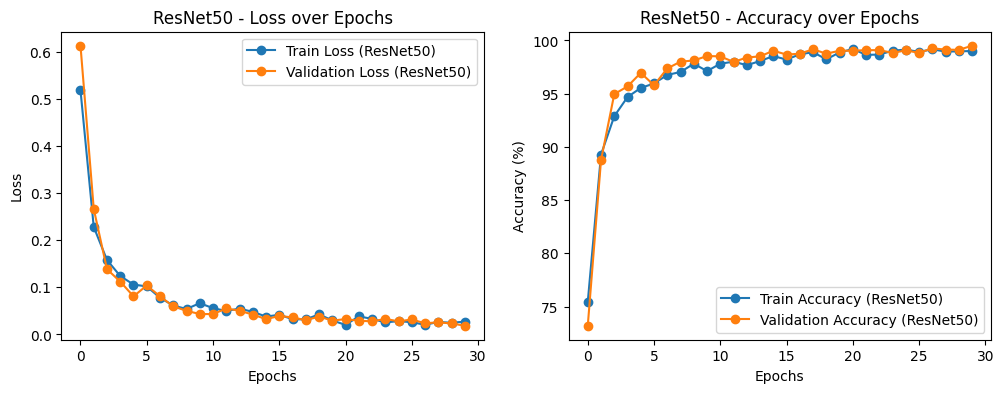

In [ ]:
num_epochs_resnet = 30
best_val_loss_resnet = float('inf')
patience_resnet = 5
counter_resnet = 0

train_losses_resnet, val_losses_resnet = [], []
train_accs_resnet, val_accs_resnet = [], []

for epoch in range(num_epochs_resnet):
    model_resnet.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(train_loader_resnet, desc=f"Epoch {epoch+1}/{num_epochs_resnet}", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), acc=100*correct/total)

    train_losses_resnet.append(running_loss / len(train_loader_resnet))
    train_accs_resnet.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs_resnet}] → Train Loss: {train_losses_resnet[-1]:.4f}, Train Accuracy: {train_accs_resnet[-1]:.2f}%")

    model_resnet.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader_resnet:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion_resnet(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses_resnet.append(val_loss / len(val_loader_resnet))
    val_accs_resnet.append(100 * correct / total)

    print(f"Validation Loss: {val_losses_resnet[-1]:.4f}, Validation Accuracy: {val_accs_resnet[-1]:.2f}%")
    scheduler_resnet.step(val_losses_resnet[-1])

    if val_losses_resnet[-1] < best_val_loss_resnet:
        best_val_loss_resnet = val_losses_resnet[-1]
        counter_resnet = 0
    else:
        counter_resnet += 1
        if counter_resnet >= patience_resnet:
            print("Early stopping!")
            break

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(train_losses_resnet, label='Train Loss (ResNet50)', marker='o')
plt.plot(val_losses_resnet, label='Validation Loss (ResNet50)', marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 - Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(train_accs_resnet, label='Train Accuracy (ResNet50)', marker='o')
plt.plot(val_accs_resnet, label='Validation Accuracy (ResNet50)', marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('ResNet50 - Accuracy over Epochs')

plt.show()

In [ ]:
torch.save(model_resnet.state_dict(), 'resnet50_lung_cancer.pth')

In [ ]:
model_resnet.load_state_dict(torch.load('resnet50_lung_cancer.pth'))
model_resnet.to(device)
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def predict_image_resnet(image_path, model_resnet, transform_resnet, device):
    image_resnet = Image.open(image_path_resnet).convert('RGB')
    image_resnet = transform_resnet(image_resnet).unsqueeze(0).to(device)
    with torch.no_grad():
        output_resnet = model_resnet(image_resnet)
        _, predicted_resnet = output_resnet.max(1)
    return predicted_resnet.item()


In [ ]:
sample_indices_resnet = random.sample(range(len(val_dataset_resnet)), 10)
for idx_resnet in sample_indices_resnet:
    image_resnet, label_resnet = val_dataset_resnet[idx_resnet]
    image_path_resnet = val_dataset_resnet.samples[idx_resnet][0]
    predicted_class_resnet = predict_image_resnet(image_path_resnet, model_resnet, transform_resnet, device)
    print(f"Actual class: {train_dataset_resnet.classes[label_resnet]} --> Predicted class by resnet: {train_dataset_resnet.classes[predicted_class_resnet]}")


Actual class: Benign cases --> Predicted class by resnet: Benign cases
Actual class: Benign cases --> Predicted class by resnet: Benign cases
Actual class: Benign cases --> Predicted class by resnet: Benign cases
Actual class: Malignant cases --> Predicted class by resnet: Malignant cases
Actual class: Normal cases --> Predicted class by resnet: Normal cases
Actual class: Malignant cases --> Predicted class by resnet: Malignant cases
Actual class: Malignant cases --> Predicted class by resnet: Malignant cases
Actual class: Malignant cases --> Predicted class by resnet: Malignant cases
Actual class: Malignant cases --> Predicted class by resnet: Malignant cases
Actual class: Malignant cases --> Predicted class by resnet: Malignant cases


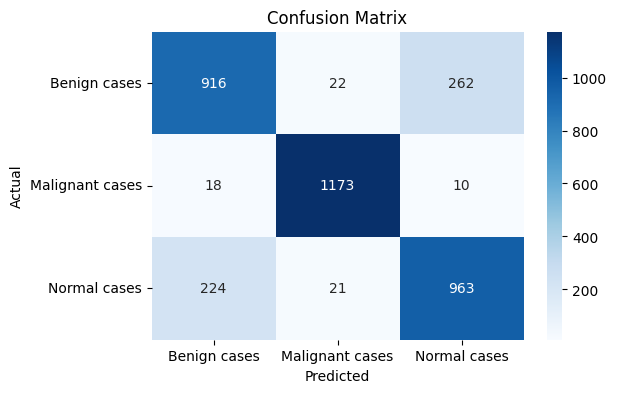

In [ ]:
y_true_resnet, y_pred_resnet = [], []
with torch.no_grad():
    for images_resnet, labels_resnet in val_loader_resnet:
        images_resnet, labels_resnet = images_resnet.to(device), labels_resnet.to(device)
        outputs_resnet = model_resnet(images_resnet)
        _, predicted_resnet = outputs_resnet.max(1)
        y_true_resnet.extend(labels_resnet.cpu().numpy())
        y_pred_resnet.extend(predicted_resnet.cpu().numpy())

cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset_resnet.classes, yticklabels=train_dataset_resnet.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true_resnet, y_pred_resnet, target_names=train_dataset_resnet.classes))


                 precision    recall  f1-score   support

   Benign cases       0.99      0.99      0.99      1200
Malignant cases       1.00      1.00      1.00      1201
   Normal cases       0.99      0.99      0.99      1208

       accuracy                           0.99      3609
      macro avg       0.99      0.99      0.99      3609
   weighted avg       0.99      0.99      0.99      3609

